<a href="https://colab.research.google.com/github/thomaslu678/gee-test/blob/main/clean/7_2_fetch_met_delta_LST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTE: Requires export_clean.csv (cleaned up export CSV with sorts and time columns)

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from datetime import timedelta
import scipy.stats as stats
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
import geopandas as gpd
from shapely.geometry import Point
import requests

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read cleaned up export csv

In [3]:
calculations_df = pd.read_csv('/content/drive/MyDrive/Year 2/Fall 2025/HONOR 3700/Data/2/export_clean_calculations.csv')

In [4]:
calculations_df

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo
0,2505,1988-12-24 01:43:00,-0.527053,0.008107,-0.042450,0.042450,0.185196
1,2527,1988-12-24 01:43:00,-0.527053,0.008107,-0.105622,0.105622,0.183640
2,2528,1988-12-24 01:43:00,-0.527053,-0.011292,-0.099890,0.099890,0.176036
3,2550,1988-12-24 01:43:00,-0.431348,-0.029073,-0.068238,0.068238,0.171996
4,2551,1988-12-24 01:43:00,-0.431348,0.008107,-0.092413,0.092413,0.181680
...,...,...,...,...,...,...,...
2646549,4618,2026-01-31 02:11:17,1.397293,0.192808,0.070690,-0.070690,0.085628
2646550,4619,2026-01-31 02:11:17,1.356276,0.306176,0.073418,-0.073418,0.127741
2646551,4620,2026-01-31 02:11:17,1.575030,0.157747,-0.135409,0.135409,0.149991
2646552,4627,2026-01-31 02:11:17,1.438309,0.157339,0.031072,-0.031072,0.071202


In [5]:
input_df = pd.read_csv('/content/drive/MyDrive/Year 2/Fall 2025/HONOR 3700/Data/2/points.csv')

In [6]:
input_df

,point_id,long,lat,distance
0,1,126.974400,37.570275,321.262762
1,2,126.974402,37.570005,311.450539
2,3,126.974403,37.569735,304.291166
3,4,126.974405,37.569464,299.974648
4,5,126.974407,37.569194,298.624287
...,...,...,...,...
4623,4624,127.044710,37.572190,309.046080
4624,4625,127.044712,37.571920,308.199775
4625,4626,127.044713,37.571649,310.265569
4626,4627,127.044715,37.571379,315.186207


In [32]:
airport_df = pd.read_csv('/content/drive/MyDrive/Year 2/Fall 2025/HONOR 3700/Data/2/airport.csv')

In [33]:
airport_df

,time,LST_K
0,1988-12-24 01:43:00,278.471180
1,1989-05-17 01:44:21,300.872883
2,1989-08-05 01:44:33,309.171835
3,1991-11-15 01:21:41,280.019543
4,1991-12-01 01:20:53,279.677741
...,...,...
594,2025-11-12 02:11:26,291.042657
595,2025-11-28 02:11:24,283.444399
596,2025-12-30 02:11:28,277.428683
597,2026-01-31 02:11:17,275.107848


In [34]:
airport_df['LST_K'] -= 273.15
airport_df.rename(columns={'LST_K': 'LST_C_A'}, inplace=True)

In [35]:
airport_df

,time,LST_C_A
0,1988-12-24 01:43:00,5.321180
1,1989-05-17 01:44:21,27.722883
2,1989-08-05 01:44:33,36.021835
3,1991-11-15 01:21:41,6.869543
4,1991-12-01 01:20:53,6.527741
...,...,...
594,2025-11-12 02:11:26,17.892657
595,2025-11-28 02:11:24,10.294399
596,2025-12-30 02:11:28,4.278683
597,2026-01-31 02:11:17,1.957848


In [18]:
input_df['point_id'].min()

1

In [19]:
point_id_1_mask = (input_df['point_id'] == 1)
point_id_1 = input_df[point_id_1_mask]

In [20]:
# rep_lat = point_id_1['lat'].mean()
# rep_long = point_id_1['long'].mean()
rep_lat = point_id_1['lat'].iloc[0]
rep_long = point_id_1['long'].iloc[0]

In [21]:
rep_lat, rep_long

(np.float64(37.57027546), np.float64(126.9743997))

# Fetch met data

In [22]:
calculations_df['time'] = pd.to_datetime(calculations_df['time'])

In [23]:
hours = (
    calculations_df['time']
    .dt.floor('H')
    .drop_duplicates()
    .sort_values()
)

hours_str = hours.dt.strftime('%Y-%m-%dT%H:%M')

/tmp/ipython-input-2803264291.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .dt.floor('H')


In [24]:
hours_str

,time
77212,1984-07-30T01:00
22645,1984-08-08T01:00
24685,1984-09-25T01:00
81720,1984-12-05T01:00
83001,1985-02-07T01:00
...,...
2451905,2025-12-22T02:00
2641777,2025-12-30T02:00
2454231,2026-01-07T02:00
2456046,2026-01-23T02:00


In [25]:
def fetch_open_meteo(lat, lon, start, end):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": "temperature_2m",
        "start_date": start.strftime('%Y-%m-%d'),
        "end_date": end.strftime('%Y-%m-%d'),
        "timezone": "UTC"
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()

In [26]:
temps = []

for year, group in hours.groupby(hours.dt.year):
    start = group.min()
    end   = group.max()

    data = fetch_open_meteo(rep_lat, rep_long, start, end)

    df = pd.DataFrame({
        "hour": pd.to_datetime(data["hourly"]["time"], utc=True),
        "temp_C": data["hourly"]["temperature_2m"]
    })

    temps.append(df)

hourly_temp = pd.concat(temps).drop_duplicates(subset="hour")

In [27]:
hourly_temp

,hour,temp_C
0,1984-07-30 00:00:00+00:00,27.3
1,1984-07-30 01:00:00+00:00,28.6
2,1984-07-30 02:00:00+00:00,29.9
3,1984-07-30 03:00:00+00:00,31.0
4,1984-07-30 04:00:00+00:00,32.0
...,...,...
595,2026-01-31 19:00:00+00:00,-6.8
596,2026-01-31 20:00:00+00:00,-7.8
597,2026-01-31 21:00:00+00:00,-8.4
598,2026-01-31 22:00:00+00:00,-8.8


In [28]:
calculations_df['hour'] = calculations_df['time'].dt.floor('H')

calculations_df['hour'] = pd.to_datetime(calculations_df['hour'], utc=True)
hourly_temp['hour'] = pd.to_datetime(hourly_temp['hour'], utc=True)

/tmp/ipython-input-342303639.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  calculations_df['hour'] = calculations_df['time'].dt.floor('H')


In [29]:
calculations_df = calculations_df.merge(
    hourly_temp,
    on='hour',
    how='left'
)

In [30]:
# calculations_df['delta_C'] = calculations_df['temp_C'] - calculations_df['LST_C']

In [31]:
calculations_df

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo,hour,temp_C
0,2505,1988-12-24 01:43:00,-0.527053,0.008107,-0.042450,0.042450,0.185196,1988-12-24 01:00:00+00:00,2.6
1,2527,1988-12-24 01:43:00,-0.527053,0.008107,-0.105622,0.105622,0.183640,1988-12-24 01:00:00+00:00,2.6
2,2528,1988-12-24 01:43:00,-0.527053,-0.011292,-0.099890,0.099890,0.176036,1988-12-24 01:00:00+00:00,2.6
3,2550,1988-12-24 01:43:00,-0.431348,-0.029073,-0.068238,0.068238,0.171996,1988-12-24 01:00:00+00:00,2.6
4,2551,1988-12-24 01:43:00,-0.431348,0.008107,-0.092413,0.092413,0.181680,1988-12-24 01:00:00+00:00,2.6
...,...,...,...,...,...,...,...,...,...
2646549,4618,2026-01-31 02:11:17,1.397293,0.192808,0.070690,-0.070690,0.085628,2026-01-31 02:00:00+00:00,-5.6
2646550,4619,2026-01-31 02:11:17,1.356276,0.306176,0.073418,-0.073418,0.127741,2026-01-31 02:00:00+00:00,-5.6
2646551,4620,2026-01-31 02:11:17,1.575030,0.157747,-0.135409,0.135409,0.149991,2026-01-31 02:00:00+00:00,-5.6
2646552,4627,2026-01-31 02:11:17,1.438309,0.157339,0.031072,-0.031072,0.071202,2026-01-31 02:00:00+00:00,-5.6


In [36]:
print(calculations_df['time'].unique())

<DatetimeArray>
['1988-12-24 01:43:00', '1989-02-26 01:43:56', '1989-03-14 01:43:50',
 '1989-05-17 01:44:21', '1989-08-05 01:44:33', '1991-11-15 01:21:41',
 '1991-12-01 01:20:53', '1984-08-08 01:34:24', '1984-09-25 01:34:59',
 '1986-06-11 01:28:45',
 ...
 '2025-06-05 02:10:27', '2025-07-23 02:10:54', '2025-08-08 02:11:03',
 '2025-08-24 02:11:10', '2025-10-27 02:11:21', '2025-11-12 02:11:26',
 '2025-11-28 02:11:24', '2025-12-14 02:11:24', '2025-12-30 02:11:28',
 '2026-01-31 02:11:17']
Length: 970, dtype: datetime64[ns]


In [37]:
input_df

,point_id,long,lat,distance
0,1,126.974400,37.570275,321.262762
1,2,126.974402,37.570005,311.450539
2,3,126.974403,37.569735,304.291166
3,4,126.974405,37.569464,299.974648
4,5,126.974407,37.569194,298.624287
...,...,...,...,...
4623,4624,127.044710,37.572190,309.046080
4624,4625,127.044712,37.571920,308.199775
4625,4626,127.044713,37.571649,310.265569
4626,4627,127.044715,37.571379,315.186207


# Fetch data for only one point in calculations_df


In [41]:
point_id = 1
# start = '1977-02-26'
# end = '2027-02-26'
# point_id_1_mask_calculations = (calculations_df['point_id'] == 1) & (calculations_df['time'] >= start) & (calculations_df['time'] <= end) & (calculations_df['delta_C'] < 10)
point_id_mask_calculations = (calculations_df['point_id'] == point_id)
point_id_calculations = calculations_df[point_id_mask_calculations]

In [42]:
point_id_calculations

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo,hour,temp_C
84,1,1989-02-26 01:43:56,9.207468,0.012678,-0.066392,0.066392,0.097498,1989-02-26 01:00:00+00:00,4.3
4289,1,1989-03-14 01:43:50,15.978566,0.015678,0.030970,-0.030970,0.108621,1989-03-14 01:00:00+00:00,7.5
8914,1,1989-05-17 01:44:21,37.265995,0.076762,0.004810,-0.004810,0.116501,1989-05-17 01:00:00+00:00,18.9
13542,1,1989-08-05 01:44:33,47.926799,0.083973,0.025084,-0.025084,0.105496,1989-08-05 01:00:00+00:00,29.2
18170,1,1991-11-15 01:21:41,6.479888,0.067048,0.023271,-0.023271,0.084012,1991-11-15 01:00:00+00:00,3.4
...,...,...,...,...,...,...,...,...,...
2609340,1,2025-02-13 02:11:14,1.598956,0.023351,-0.039800,0.039800,0.000436,2025-02-13 02:00:00+00:00,0.9
2618779,1,2025-06-05 02:10:27,36.667841,0.294780,-0.059942,0.059942,0.101221,2025-06-05 02:00:00+00:00,25.1
2629244,1,2025-10-27 02:11:21,14.228540,0.205308,-0.103877,0.103877,0.009688,2025-10-27 02:00:00+00:00,7.4
2633806,1,2025-11-12 02:11:26,15.356486,0.120654,-0.144367,0.144367,0.030180,2025-11-12 02:00:00+00:00,11.1


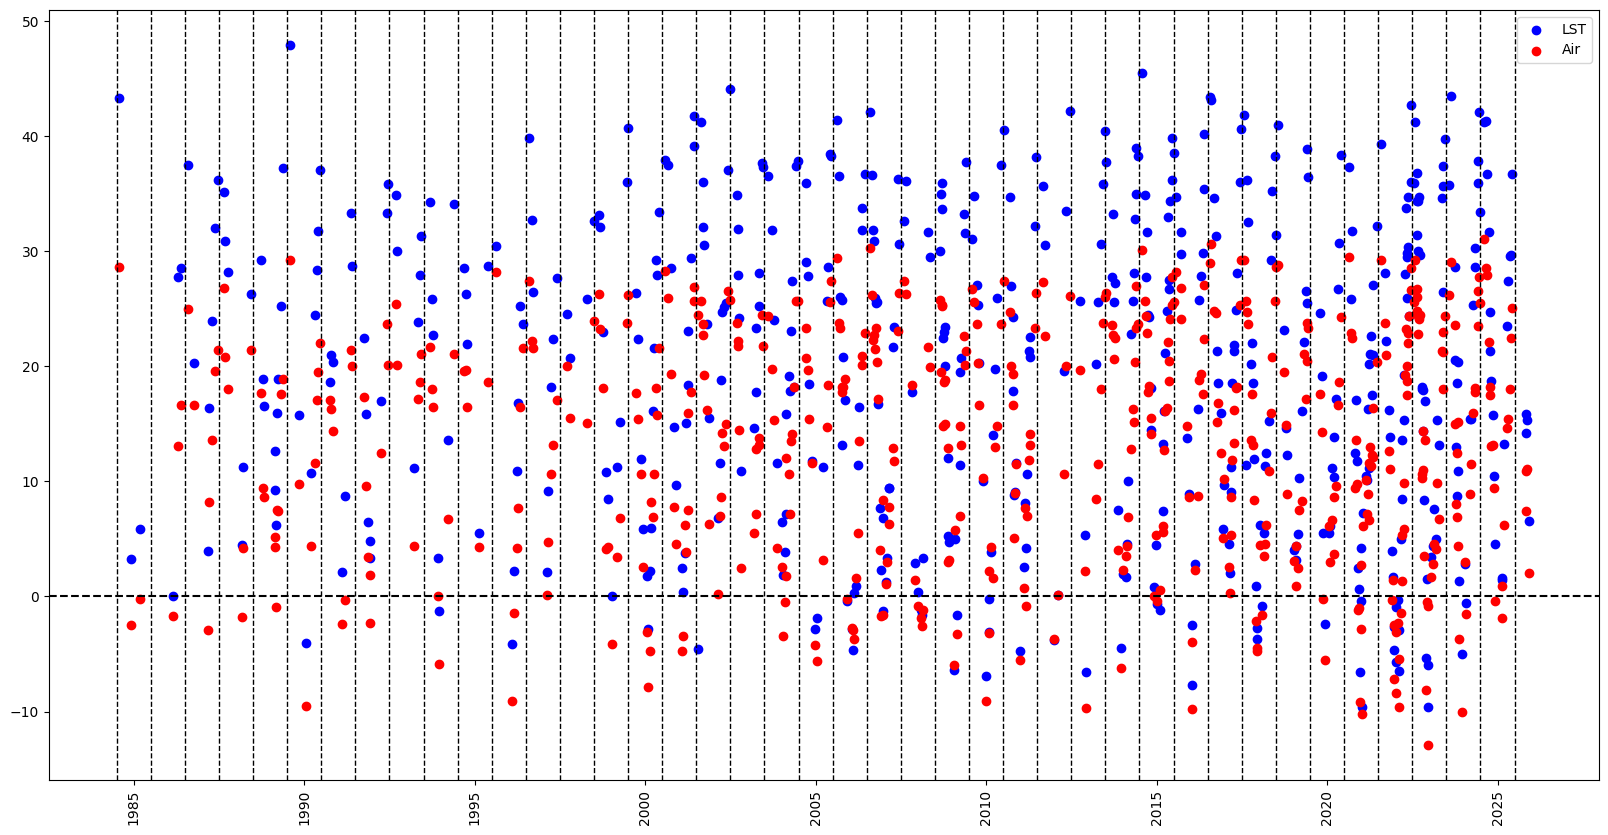

In [44]:
plt.figure(figsize=(20, 10))
# plt.scatter(point_id_calculations['time'], point_id_calculations['delta_C'], color='purple', label='Delta')
plt.scatter(point_id_calculations['time'], point_id_calculations['LST_C'], color='blue', label='LST')
plt.scatter(point_id_calculations['time'], point_id_calculations['temp_C'], color='red', label='Air')

years = point_id_calculations['time'].dt.year.unique()
for year in years:
    plt.axvline(pd.to_datetime(f'{year}-07-01'), color='black', linestyle='--', lw=1)

plt.axhline(y=0, color='black', linestyle='--')

plt.legend()
plt.xticks(rotation='vertical')
plt.show()

## Divide into seasons

In [47]:
def get_season(month):
    if month in [12, 1, 2]:
        return 1  # Winter
    elif month in [3, 4, 5]:
        return 2  # Spring
    elif month in [6, 7, 8]:
        return 3  # Summer
    else:  # 9, 10, 11
        return 4  # Fall

point_id_calculations['season'] = point_id_calculations['time'].dt.month.apply(get_season)

/tmp/ipython-input-3511896217.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_id_calculations['season'] = point_id_calculations['time'].dt.month.apply(get_season)


In [48]:
point_id_calculations

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo,hour,temp_C,season
84,1,1989-02-26 01:43:56,9.207468,0.012678,-0.066392,0.066392,0.097498,1989-02-26 01:00:00+00:00,4.3,1
4289,1,1989-03-14 01:43:50,15.978566,0.015678,0.030970,-0.030970,0.108621,1989-03-14 01:00:00+00:00,7.5,2
8914,1,1989-05-17 01:44:21,37.265995,0.076762,0.004810,-0.004810,0.116501,1989-05-17 01:00:00+00:00,18.9,2
13542,1,1989-08-05 01:44:33,47.926799,0.083973,0.025084,-0.025084,0.105496,1989-08-05 01:00:00+00:00,29.2,3
18170,1,1991-11-15 01:21:41,6.479888,0.067048,0.023271,-0.023271,0.084012,1991-11-15 01:00:00+00:00,3.4,4
...,...,...,...,...,...,...,...,...,...,...
2609340,1,2025-02-13 02:11:14,1.598956,0.023351,-0.039800,0.039800,0.000436,2025-02-13 02:00:00+00:00,0.9,1
2618779,1,2025-06-05 02:10:27,36.667841,0.294780,-0.059942,0.059942,0.101221,2025-06-05 02:00:00+00:00,25.1,3
2629244,1,2025-10-27 02:11:21,14.228540,0.205308,-0.103877,0.103877,0.009688,2025-10-27 02:00:00+00:00,7.4,4
2633806,1,2025-11-12 02:11:26,15.356486,0.120654,-0.144367,0.144367,0.030180,2025-11-12 02:00:00+00:00,11.1,4


/tmp/ipython-input-3530173611.py:17: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  years = pd.date_range(start=start_date, end=end_date, freq='Y').year.unique()


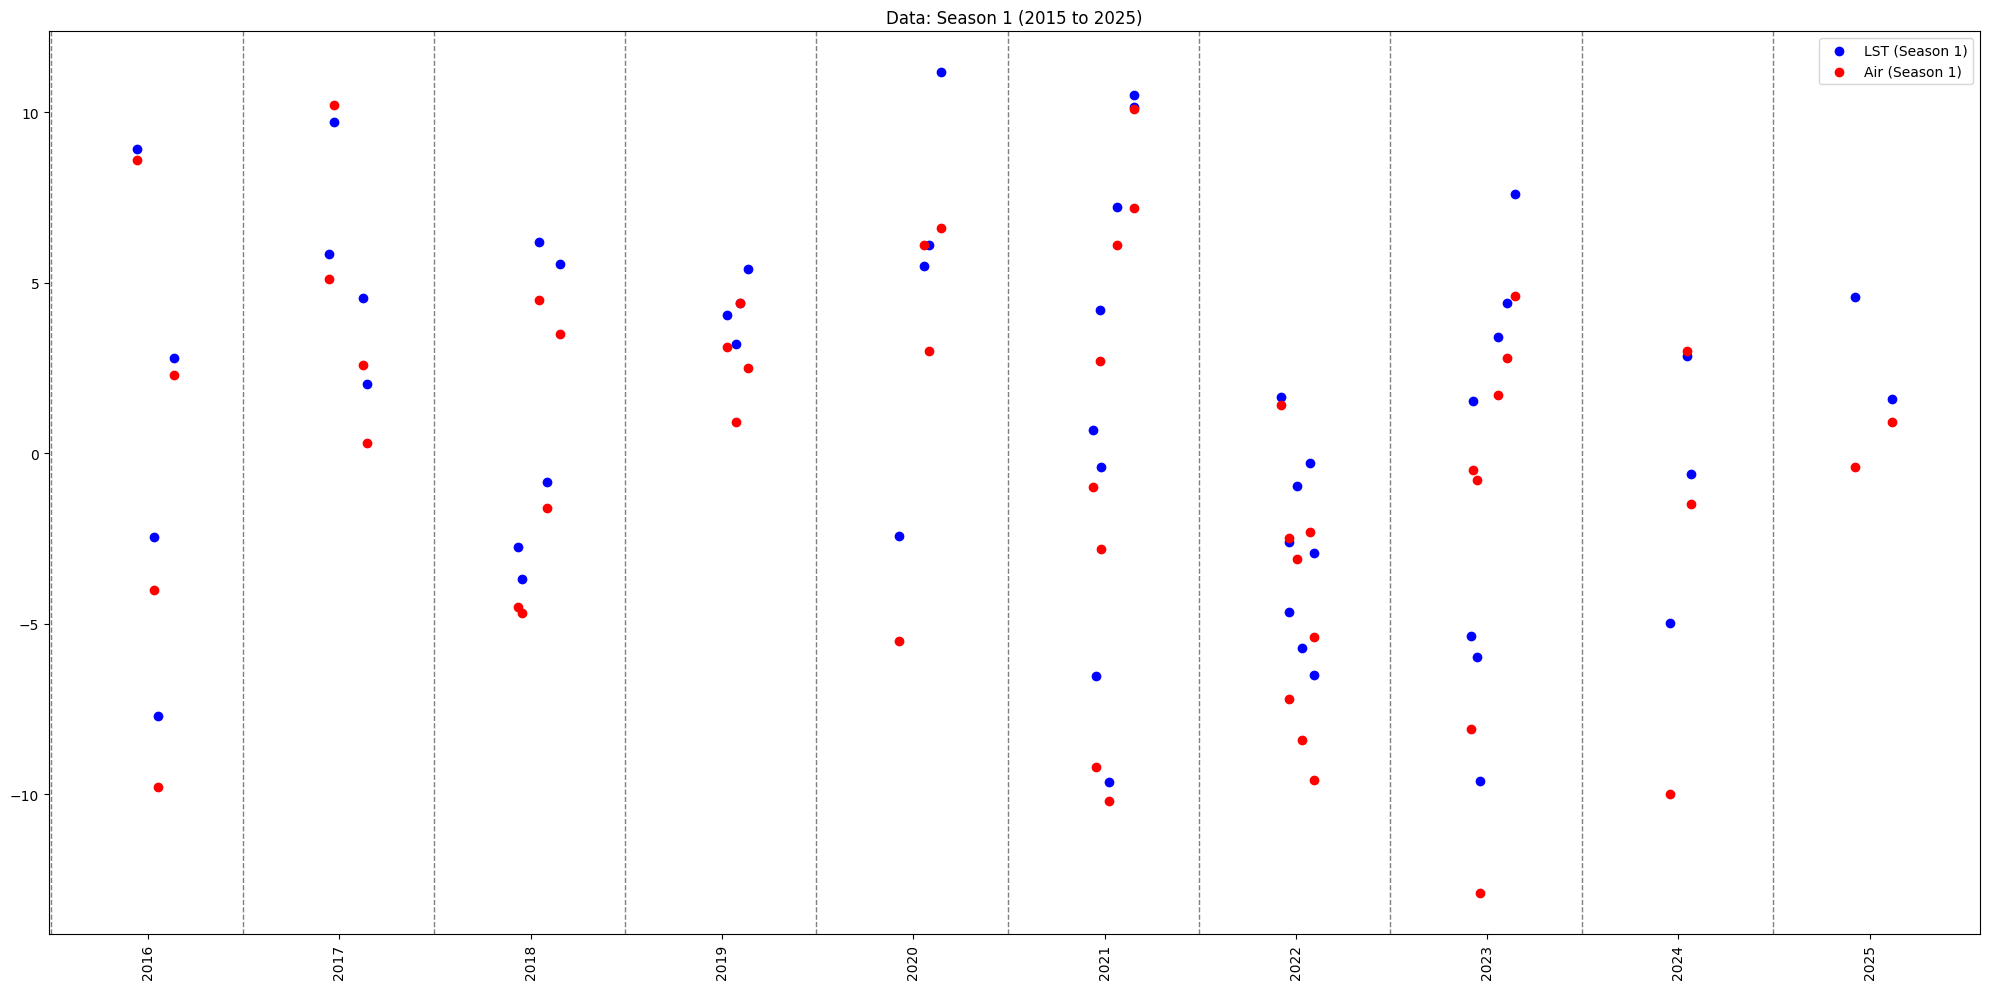

In [59]:
# 1. FILTER: Only rows where season is 1
df_season1 = point_id_calculations[point_id_calculations['season'] == 1].copy()

# 2. WINDOW: Set 5-year window (e.g., Jan 2015 - Jan 2020)
# Example: Using the last 5 years available in the data
start_date = pd.Timestamp('2015-02-21')
end_date = pd.Timestamp('2025-02-21')
df_window = df_season1[(df_season1['time'] >= start_date) & (df_season1['time'] <= end_date)]

plt.figure(figsize=(20, 10))

# Plotting filtered data
plt.scatter(df_window['time'], df_window['LST_C'], color='blue', label='LST (Season 1)')
plt.scatter(df_window['time'], df_window['temp_C'], color='red', label='Air (Season 1)')

# Vertical lines for years
years = pd.date_range(start=start_date, end=end_date, freq='Y').year.unique()
for year in years:
    plt.axvline(pd.to_datetime(f'{year}-07-01'), color='black', linestyle='--', lw=1, alpha=0.5)

plt.title(f'Data: Season 1 ({start_date.year} to {end_date.year})')
plt.legend()
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

## Check if airport data can be easily merged

In [64]:
point_id_calculations

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo,hour,temp_C,season
84,1,1989-02-26 01:43:56,9.207468,0.012678,-0.066392,0.066392,0.097498,1989-02-26 01:00:00+00:00,4.3,1
4289,1,1989-03-14 01:43:50,15.978566,0.015678,0.030970,-0.030970,0.108621,1989-03-14 01:00:00+00:00,7.5,2
8914,1,1989-05-17 01:44:21,37.265995,0.076762,0.004810,-0.004810,0.116501,1989-05-17 01:00:00+00:00,18.9,2
13542,1,1989-08-05 01:44:33,47.926799,0.083973,0.025084,-0.025084,0.105496,1989-08-05 01:00:00+00:00,29.2,3
18170,1,1991-11-15 01:21:41,6.479888,0.067048,0.023271,-0.023271,0.084012,1991-11-15 01:00:00+00:00,3.4,4
...,...,...,...,...,...,...,...,...,...,...
2609340,1,2025-02-13 02:11:14,1.598956,0.023351,-0.039800,0.039800,0.000436,2025-02-13 02:00:00+00:00,0.9,1
2618779,1,2025-06-05 02:10:27,36.667841,0.294780,-0.059942,0.059942,0.101221,2025-06-05 02:00:00+00:00,25.1,3
2629244,1,2025-10-27 02:11:21,14.228540,0.205308,-0.103877,0.103877,0.009688,2025-10-27 02:00:00+00:00,7.4,4
2633806,1,2025-11-12 02:11:26,15.356486,0.120654,-0.144367,0.144367,0.030180,2025-11-12 02:00:00+00:00,11.1,4


In [68]:
airport_df['time'] = pd.to_datetime(airport_df['time'])

In [69]:
airport_df

,time,LST_C_A
0,1988-12-24 01:43:00,5.321180
1,1989-05-17 01:44:21,27.722883
2,1989-08-05 01:44:33,36.021835
3,1991-11-15 01:21:41,6.869543
4,1991-12-01 01:20:53,6.527741
...,...,...
594,2025-11-12 02:11:26,17.892657
595,2025-11-28 02:11:24,10.294399
596,2025-12-30 02:11:28,4.278683
597,2026-01-31 02:11:17,1.957848


In [70]:
# Create a boolean mask: True where df1['value'] is in df2['ref']
boolean_mask = airport_df['time'].isin(point_id_calculations['time'])

# Sum the True values to get the total count of occurrences
total_occurrences_count = boolean_mask.sum()

print(f"Total count of values in df1['value'] present in df2['ref']: {total_occurrences_count}")

Total count of values in df1['value'] present in df2['ref']: 369


In [71]:
merged_airport_df = pd.merge(point_id_calculations, airport_df, on='time')

In [72]:
merged_airport_df

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo,hour,temp_C,season,LST_C_A
0,1,1989-05-17 01:44:21,37.265995,0.076762,0.004810,-0.004810,0.116501,1989-05-17 01:00:00+00:00,18.9,2,27.722883
1,1,1989-08-05 01:44:33,47.926799,0.083973,0.025084,-0.025084,0.105496,1989-08-05 01:00:00+00:00,29.2,3,36.021835
2,1,1991-11-15 01:21:41,6.479888,0.067048,0.023271,-0.023271,0.084012,1991-11-15 01:00:00+00:00,3.4,4,6.869543
3,1,1991-12-01 01:20:53,4.822149,0.043550,-0.040337,0.040337,0.102312,1991-12-01 01:00:00+00:00,1.9,1,6.527741
4,1,1984-07-30 01:40:17,43.291964,0.094642,-0.053041,0.053041,0.109382,1984-07-30 01:00:00+00:00,28.6,3,31.120395
...,...,...,...,...,...,...,...,...,...,...,...
364,1,2025-02-13 02:11:14,1.598956,0.023351,-0.039800,0.039800,0.000436,2025-02-13 02:00:00+00:00,0.9,1,7.016518
365,1,2025-06-05 02:10:27,36.667841,0.294780,-0.059942,0.059942,0.101221,2025-06-05 02:00:00+00:00,25.1,3,30.053972
366,1,2025-10-27 02:11:21,14.228540,0.205308,-0.103877,0.103877,0.009688,2025-10-27 02:00:00+00:00,7.4,4,18.265221
367,1,2025-11-12 02:11:26,15.356486,0.120654,-0.144367,0.144367,0.030180,2025-11-12 02:00:00+00:00,11.1,4,17.892657


## Use met data to check validity of both LST data

In [77]:
merged_airport_df['LST_diff'] = (
    merged_airport_df['LST_C'] - merged_airport_df['LST_C_A']
)

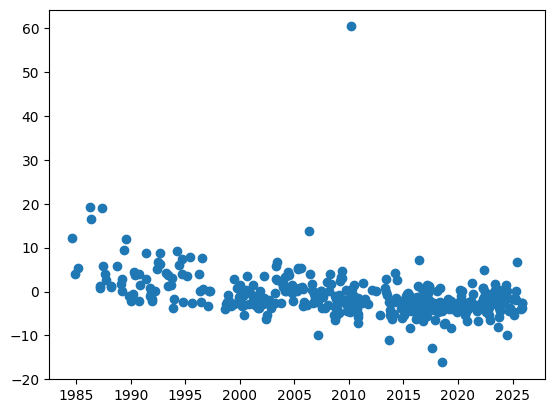

In [79]:
plt.scatter(merged_airport_df['time'], merged_airport_df['LST_diff'])
plt.show()

In [80]:
mean_diff = merged_airport_df['LST_diff'].mean()
std_diff = merged_airport_df['LST_diff'].std()

merged_airport_df['LST_diff_z'] = (
    (merged_airport_df['LST_diff'] - mean_diff) / std_diff
)

merged_airport_df['LST_disagreement_flag'] = (
    merged_airport_df['LST_diff_z'].abs() > 3
)

In [82]:
merged_airport_df['LST_air_diff'] = (
    merged_airport_df['LST_C'] - merged_airport_df['temp_C']
)

merged_airport_df['LST_A_air_diff'] = (
    merged_airport_df['LST_C_A'] - merged_airport_df['temp_C']
)

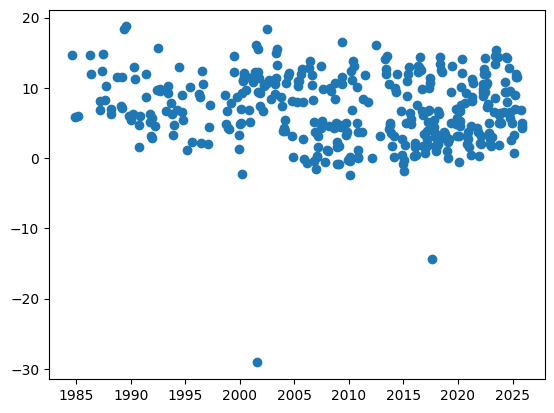

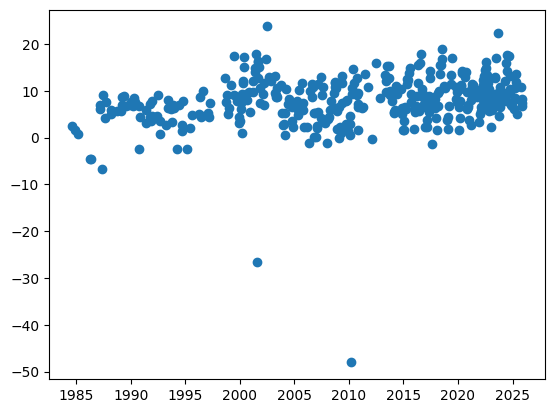

In [83]:
plt.scatter(merged_airport_df['time'], merged_airport_df['LST_air_diff'])
plt.show()

plt.scatter(merged_airport_df['time'], merged_airport_df['LST_A_air_diff'])
plt.show()

In [84]:
merged_airport_df['hour'] = merged_airport_df['time'].dt.hour

In [85]:
hourly_stats = (
    merged_airport_df
    .groupby('hour')['LST_C']
    .agg(['mean', 'std'])
)

In [86]:
merged_airport_df = merged_airport_df.merge(
    hourly_stats,
    on='hour',
    how='left'
)

In [87]:
merged_airport_df['hourly_z'] = (
    (merged_airport_df['LST_C'] - merged_airport_df['mean']) /
    merged_airport_df['std']
)

merged_airport_df['diurnal_flag'] = (
    merged_airport_df['hourly_z'].abs() > 3
)

In [89]:
from sklearn.ensemble import IsolationForest

features = merged_airport_df[
    ['LST_C', 'LST_C_A', 'temp_C']
].dropna()

iso = IsolationForest(contamination=0.01)
merged_airport_df.loc[features.index, 'iso_flag'] = (
    iso.fit_predict(features) == -1
)

In [91]:
merged_airport_df

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo,hour,temp_C,season,...,iso_flag,LST_diff,LST_diff_z,LST_disagreement_flag,LST_air_diff,LST_A_air_diff,mean,std,hourly_z,diurnal_flag
0,1,1989-05-17 01:44:21,37.265995,0.076762,0.004810,-0.004810,0.116501,1,18.9,2,...,False,9.543112,1.999161,False,18.365995,8.822883,20.972915,12.224446,1.332828,False
1,1,1989-08-05 01:44:33,47.926799,0.083973,0.025084,-0.025084,0.105496,1,29.2,3,...,False,11.904964,2.451191,False,18.726799,6.821835,20.972915,12.224446,2.204917,False
2,1,1991-11-15 01:21:41,6.479888,0.067048,0.023271,-0.023271,0.084012,1,3.4,4,...,False,-0.389654,0.098150,False,3.079888,3.469543,20.972915,12.224446,-1.185577,False
3,1,1991-12-01 01:20:53,4.822149,0.043550,-0.040337,0.040337,0.102312,1,1.9,1,...,False,-1.705592,-0.153705,False,2.922149,4.627741,20.972915,12.224446,-1.321186,False
4,1,1984-07-30 01:40:17,43.291964,0.094642,-0.053041,0.053041,0.109382,1,28.6,3,...,False,12.171569,2.502216,False,14.691964,2.520395,20.972915,12.224446,1.825772,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,1,2025-02-13 02:11:14,1.598956,0.023351,-0.039800,0.039800,0.000436,2,0.9,1,...,False,-5.417562,-0.864131,False,0.698956,6.116518,20.291083,13.780525,-1.356416,False
365,1,2025-06-05 02:10:27,36.667841,0.294780,-0.059942,0.059942,0.101221,2,25.1,3,...,False,6.613869,1.438540,False,11.567841,4.953972,20.291083,13.780525,1.188399,False
366,1,2025-10-27 02:11:21,14.228540,0.205308,-0.103877,0.103877,0.009688,2,7.4,4,...,False,-4.036682,-0.599847,False,6.828540,10.865221,20.291083,13.780525,-0.439936,False
367,1,2025-11-12 02:11:26,15.356486,0.120654,-0.144367,0.144367,0.030180,2,11.1,4,...,False,-2.536171,-0.312667,False,4.256486,6.792657,20.291083,13.780525,-0.358085,False


In [92]:
flag_mask = (merged_airport_df['iso_flag'] == True) | (merged_airport_df['LST_disagreement_flag'] == True) | (merged_airport_df['diurnal_flag'] == True)
merged_airport_df[flag_mask]

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo,hour,temp_C,season,...,iso_flag,LST_diff,LST_diff_z,LST_disagreement_flag,LST_air_diff,LST_A_air_diff,mean,std,hourly_z,diurnal_flag
7,1,1986-04-15 01:36:29,27.753645,0.040882,0.040844,-0.040844,0.103231,1,13.1,2,...,False,19.270797,3.860922,True,14.653645,-4.617152,20.972915,12.224446,0.554686,False
8,1,1986-05-17 01:35:40,28.556880,0.106726,0.006495,-0.006495,0.111866,1,16.6,2,...,False,16.519291,3.334317,True,11.956880,-4.562411,20.972915,12.224446,0.620393,False
11,1,1987-05-20 01:34:59,31.974900,0.101426,-0.012906,0.012906,0.118349,1,19.6,2,...,False,19.140912,3.836064,True,12.374900,-6.766012,20.972915,12.224446,0.899999,False
116,1,2010-03-16 02:02:00,13.999532,-0.001779,-0.004025,0.004025,0.066913,2,1.6,2,...,True,60.434012,11.739064,True,12.399532,-48.034479,20.291083,13.780525,-0.456554,False
139,1,2001-07-21 02:00:21,-4.594496,-0.238930,0.238930,-0.238930,1.277710,2,24.5,3,...,True,-2.430212,-0.292388,False,-29.094496,-26.664284,20.291083,13.780525,-1.805851,False
217,1,2016-01-20 02:12:44,-7.708313,-0.044134,-0.217194,0.217194,0.024019,2,-9.8,1,...,True,-4.334049,-0.656760,False,2.091687,6.425737,20.291083,13.780525,-2.031809,False
276,1,2016-08-07 02:11:04,43.155243,0.236605,-0.066060,0.066060,0.072811,2,30.6,3,...,True,-5.393636,-0.859552,False,12.555243,17.948879,20.291083,13.780525,1.659165,False


In [101]:
merged_airport_df_filtered = merged_airport_df[~flag_mask]

In [102]:
merged_airport_df_filtered.columns

Index(['point_id', 'time', 'LST_C', 'NDVI', 'NDBI', 'NDMI', 'Albedo', 'hour',
       'temp_C', 'season', 'LST_C_A', 'iso_flag', 'LST_diff', 'LST_diff_z',
       'LST_disagreement_flag', 'LST_air_diff', 'LST_A_air_diff', 'mean',
       'std', 'hourly_z', 'diurnal_flag'],
      dtype='object')

In [109]:
columns_to_drop = ['point_id', 'hour', 'iso_flag', 'LST_diff_z',
       'LST_disagreement_flag', 'LST_air_diff', 'LST_A_air_diff', 'mean',
       'std', 'hourly_z', 'diurnal_flag', 'temp_C', 'LST_C', 'LST_C_A']

In [110]:
merged_airport_df_clean = merged_airport_df_filtered.drop(columns=columns_to_drop)

In [111]:
merged_airport_df_clean

,time,NDVI,NDBI,NDMI,Albedo,season,LST_diff
0,1989-05-17 01:44:21,0.076762,0.004810,-0.004810,0.116501,2,9.543112
1,1989-08-05 01:44:33,0.083973,0.025084,-0.025084,0.105496,3,11.904964
2,1991-11-15 01:21:41,0.067048,0.023271,-0.023271,0.084012,4,-0.389654
3,1991-12-01 01:20:53,0.043550,-0.040337,0.040337,0.102312,1,-1.705592
4,1984-07-30 01:40:17,0.094642,-0.053041,0.053041,0.109382,3,12.171569
...,...,...,...,...,...,...,...
364,2025-02-13 02:11:14,0.023351,-0.039800,0.039800,0.000436,1,-5.417562
365,2025-06-05 02:10:27,0.294780,-0.059942,0.059942,0.101221,3,6.613869
366,2025-10-27 02:11:21,0.205308,-0.103877,0.103877,0.009688,4,-4.036682
367,2025-11-12 02:11:26,0.120654,-0.144367,0.144367,0.030180,4,-2.536171


In [112]:
merged_airport_df_clean.columns

Index(['time', 'NDVI', 'NDBI', 'NDMI', 'Albedo', 'season', 'LST_diff'], dtype='object')

## create pairwise change in feature vector

In [113]:
import itertools

df = merged_airport_df_clean.copy()
df["original_index"] = df.index

delta_rows = []

for season_value, group in df.groupby("season"):

    for i, j in itertools.combinations(group.index, 2):
        row_i = group.loc[i]
        row_j = group.loc[j]

        delta_rows.append({
            "initial": i,
            "final": j,
            "delta_time": (row_j["time"] - row_i["time"]).total_seconds(),
            "delta_NDVI": row_j["NDVI"] - row_i["NDVI"],
            "delta_NDBI": row_j["NDBI"] - row_i["NDBI"],
            "delta_NDMI": row_j["NDMI"] - row_i["NDMI"],
            "delta_Albedo": row_j["Albedo"] - row_i["Albedo"],
            "delta_LST_diff": row_j["LST_diff"] - row_i["LST_diff"],
        })

delta_df = pd.DataFrame(delta_rows)

In [114]:
delta_df

,initial,final,delta_time,delta_NDVI,delta_NDBI,delta_NDMI,delta_Albedo,delta_LST_diff
0,3,5,-220491592.0,0.030604,-0.060631,0.060631,-0.028791,5.766200
1,3,18,-87781192.0,-0.018957,0.017367,-0.017367,-0.009589,3.500052
2,3,22,-58751249.0,0.009447,0.020237,-0.020237,-0.019705,-0.475105
3,3,33,692079.0,0.028090,0.035513,-0.035513,-0.022004,-0.406744
4,3,45,64282318.0,-0.015205,0.006155,-0.006155,-0.019146,0.102541
...,...,...,...,...,...,...,...,...
17389,363,367,31795218.0,-0.043102,0.067103,-0.067103,0.009865,1.811551
17390,363,368,33177616.0,-0.014465,0.090868,-0.090868,0.001137,0.591317
17391,366,367,1382405.0,-0.084654,-0.040490,0.040490,0.020492,1.500511
17392,366,368,2764803.0,-0.056017,-0.016724,0.016724,0.011764,0.280278


# Fit linear regression

In [ ]:
seconds_per_year = 365.2425 * 24 * 3600

calculations_df['time_years'] = (
    calculations_df['time'].astype('int64') / 1e9
) / seconds_per_year

In [ ]:
def compute_slope(group):
    # Need at least 2 points to fit a line
    if len(group) < 2:
        return np.nan

    x = group['time_years'].values
    y = group['delta_C'].values

    m, b = np.polyfit(x, y, 1)
    return m

In [ ]:
point_id_167_calculations

NameError: name 'point_id_167_calculations' is not defined

In [ ]:
m_df = (
    calculations_df
    .groupby('point_id', as_index=False)
    .apply(compute_slope)
    .rename(columns={None: 'm'})
)

/tmp/ipython-input-3052817466.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_slope)


In [ ]:
input_df = input_df.merge(
    m_df,
    on='point_id',
    how='left'
)

In [ ]:
input_df

,point_id,long,lat,distance,m
0,1,126.974400,37.570275,321.262762,0.065098
1,2,126.974402,37.570005,311.450539,0.063412
2,3,126.974403,37.569735,304.291166,0.037558
3,4,126.974405,37.569464,299.974648,0.023624
4,5,126.974407,37.569194,298.624287,0.008761
...,...,...,...,...,...
4623,4624,127.044710,37.572190,309.046080,0.037662
4624,4625,127.044712,37.571920,308.199775,0.007901
4625,4626,127.044713,37.571649,310.265569,-0.023929
4626,4627,127.044715,37.571379,315.186207,-0.026201


# Export to .tif

In [ ]:
input_df['m'] = pd.to_numeric(input_df['m'], errors='coerce')

In [ ]:
gdf = gpd.GeoDataFrame(
    input_df,
    geometry=gpd.points_from_xy(
        input_df['long'],
        input_df['lat']
    ),
    crs="EPSG:4326"
)

gdf_5179 = gdf.to_crs("EPSG:5179")

In [ ]:
gdf_5179['m'].isna().sum()

np.int64(0)

In [ ]:
pixel_size = 30

xs = gdf_5179.geometry.x.values
ys = gdf_5179.geometry.y.values

xmin = xs.min() - pixel_size / 2
ymax = ys.max() + pixel_size / 2

width = int((xs.max() - xs.min()) / pixel_size) + 1
height = int((ys.max() - ys.min()) / pixel_size) + 1

transform = from_origin(
    xmin,
    ymax,
    pixel_size,
    pixel_size
)

In [ ]:
shapes = (
    (geom, value)
    for geom, value in zip(gdf_5179.geometry, gdf_5179['m'])
)

raster = rasterize(
    shapes=shapes,
    out_shape=(height, width),
    transform=transform,
    fill=np.nan,
    dtype="float32"
)

In [ ]:
path = "/content/sample_data/input_df_m.tif"

with rasterio.open(
    path,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="float32",
    crs="EPSG:5179",
    transform=transform,
    nodata=np.nan
) as dst:
    dst.write(raster, 1)

# Get final dataset

In [ ]:
merged_df = pd.merge(calculations_df, input_df, on="point_id")

In [ ]:
merged_df['hour_of_day'] = merged_df['time'].dt.hour

In [ ]:
merged_df['month'] = merged_df['time'].dt.month

In [ ]:
merged_df

,point_id,time,LST_C,NDVI,NDBI,NDMI,Albedo,hour,temperature_C,delta_C,time_num,time_years,long,lat,distance,m,hour_of_day,month
0,2505,1988-12-24 01:43:00+00:00,-0.527053,0.008107,-0.042450,0.042450,0.185196,1988-12-24 01:00:00+00:00,2.7,3.227053,5.989310e+08,18.979367,127.013452,37.572606,317.553292,-0.029627,1,12
1,2527,1988-12-24 01:43:00+00:00,-0.527053,0.008107,-0.105622,0.105622,0.183640,1988-12-24 01:00:00+00:00,2.7,3.227053,5.989310e+08,18.979367,127.013792,37.572608,317.478476,-0.003934,1,12
2,2528,1988-12-24 01:43:00+00:00,-0.527053,-0.011292,-0.099890,0.099890,0.176036,1988-12-24 01:00:00+00:00,2.7,3.227053,5.989310e+08,18.979367,127.013794,37.572337,287.478569,-0.007349,1,12
3,2550,1988-12-24 01:43:00+00:00,-0.431348,-0.029073,-0.068238,0.068238,0.171996,1988-12-24 01:00:00+00:00,2.7,3.131348,5.989310e+08,18.979367,127.014133,37.572339,287.403753,-0.007378,1,12
4,2551,1988-12-24 01:43:00+00:00,-0.431348,0.008107,-0.092413,0.092413,0.181680,1988-12-24 01:00:00+00:00,2.7,3.131348,5.989310e+08,18.979367,127.014135,37.572068,257.403847,-0.019299,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646549,4618,2026-01-31 02:11:17+00:00,1.397293,0.192808,0.070690,-0.070690,0.085628,2026-01-31 02:00:00+00:00,-5.6,-6.997293,1.769825e+09,56.083537,127.044375,37.571377,285.926939,-0.037815,2,1
2646550,4619,2026-01-31 02:11:17+00:00,1.356276,0.306176,0.073418,-0.073418,0.127741,2026-01-31 02:00:00+00:00,-5.6,-6.956276,1.769825e+09,56.083537,127.044377,37.571107,294.332867,-0.026298,2,1
2646551,4620,2026-01-31 02:11:17+00:00,1.575030,0.157747,-0.135409,0.135409,0.149991,2026-01-31 02:00:00+00:00,-5.6,-7.175030,1.769825e+09,56.083537,127.044379,37.570837,305.465969,-0.020183,2,1
2646552,4627,2026-01-31 02:11:17+00:00,1.438309,0.157339,0.031072,-0.031072,0.071202,2026-01-31 02:00:00+00:00,-5.6,-7.038309,1.769825e+09,56.083537,127.044715,37.571379,315.186207,-0.031023,2,1


In [ ]:
merged_df.columns

Index(['point_id', 'time', 'LST_C', 'NDVI', 'NDBI', 'NDMI', 'Albedo', 'hour',
       'temperature_C', 'delta_C', 'time_num', 'time_years', 'long', 'lat',
       'distance', 'm', 'hour_of_day', 'month'],
      dtype='object')

In [ ]:
columns = ['NDVI', 'NDBI', 'NDMI', 'Albedo', 'time_years', 'long', 'lat',
       'distance', 'hour_of_day', 'month', 'm']

In [ ]:
export_df = merged_df[columns]

In [ ]:
export_df

,NDVI,NDBI,NDMI,Albedo,time_years,long,lat,distance,hour_of_day,month,m
0,0.008107,-0.042450,0.042450,0.185196,18.979367,127.013452,37.572606,317.553292,1,12,-0.029627
1,0.008107,-0.105622,0.105622,0.183640,18.979367,127.013792,37.572608,317.478476,1,12,-0.003934
2,-0.011292,-0.099890,0.099890,0.176036,18.979367,127.013794,37.572337,287.478569,1,12,-0.007349
3,-0.029073,-0.068238,0.068238,0.171996,18.979367,127.014133,37.572339,287.403753,1,12,-0.007378
4,0.008107,-0.092413,0.092413,0.181680,18.979367,127.014135,37.572068,257.403847,1,12,-0.019299
...,...,...,...,...,...,...,...,...,...,...,...
2646549,0.192808,0.070690,-0.070690,0.085628,56.083537,127.044375,37.571377,285.926939,2,1,-0.037815
2646550,0.306176,0.073418,-0.073418,0.127741,56.083537,127.044377,37.571107,294.332867,2,1,-0.026298
2646551,0.157747,-0.135409,0.135409,0.149991,56.083537,127.044379,37.570837,305.465969,2,1,-0.020183
2646552,0.157339,0.031072,-0.031072,0.071202,56.083537,127.044715,37.571379,315.186207,2,1,-0.031023


In [ ]:
export_df.columns

Index(['NDVI', 'NDBI', 'NDMI', 'Albedo', 'time_years', 'long', 'lat',
       'distance', 'hour_of_day', 'month', 'm'],
      dtype='object')

In [ ]:
export_df.to_csv('dataset.csv', index=False)